## Homework: SQLAlchemy Homework - Surfs Up!
## Name: Aaron Paul Lewis
## July 18, 2020

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (14.0, 8.0)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt
import time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Initialize the Base object using the automap_base in order to refelect the database.
from sqlalchemy.ext.automap import automap_base
Base = automap_base()

In [5]:
# We need an engine connected to the hawaii.sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

## Explore Database

In [6]:
# Use the Inspector to explore the hawaii.sqlite database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types for the measurement table.
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'], col["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Use Inspector to print the column names and types for the station table.
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Refection of hawaii.sqlite database

In [9]:
# Use the prepare method on the Base object create a refection of the entire database.
Base.prepare(engine, reflect=True)

In [10]:
#The relection created ORM objects of tables in the database, and accessible under the class property of the automap Base.
Base.classes.keys()

['measurement', 'station']

In [11]:
# Let's create reference to the ORM objects.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session link for Python to interact with the database.
session = Session(engine)

In [13]:
# Display the reflected measurement table.
measurements = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
               order_by(Measurement.id).all()
for meas in measurements[:5]:
    print(f"id: {meas.id},  station: {meas.station},  date: {meas.date},  prcp: {meas.prcp},  tobs: {meas.tobs}")

id: 1,  station: USC00519397,  date: 2010-01-01,  prcp: 0.08,  tobs: 65.0
id: 2,  station: USC00519397,  date: 2010-01-02,  prcp: 0.0,  tobs: 63.0
id: 3,  station: USC00519397,  date: 2010-01-03,  prcp: 0.0,  tobs: 74.0
id: 4,  station: USC00519397,  date: 2010-01-04,  prcp: 0.0,  tobs: 76.0
id: 5,  station: USC00519397,  date: 2010-01-06,  prcp: None,  tobs: 73.0


In [14]:
# Display the reflected station table.
stations = session.query(Station).order_by(Station.id)
for stations in stations[:]:
    print(f"id: {stations.id},  station: {stations.station},  name: {stations.name},\
    lat: {stations.latitude},  lon: {stations.longitude},  elev: {stations.elevation}")

id: 1,  station: USC00519397,  name: WAIKIKI 717.2, HI US,    lat: 21.2716,  lon: -157.8168,  elev: 3.0
id: 2,  station: USC00513117,  name: KANEOHE 838.1, HI US,    lat: 21.4234,  lon: -157.8015,  elev: 14.6
id: 3,  station: USC00514830,  name: KUALOA RANCH HEADQUARTERS 886.9, HI US,    lat: 21.5213,  lon: -157.8374,  elev: 7.0
id: 4,  station: USC00517948,  name: PEARL CITY, HI US,    lat: 21.3934,  lon: -157.9751,  elev: 11.9
id: 5,  station: USC00518838,  name: UPPER WAHIAWA 874.3, HI US,    lat: 21.4992,  lon: -158.0111,  elev: 306.6
id: 6,  station: USC00519523,  name: WAIMANALO EXPERIMENTAL FARM, HI US,    lat: 21.33556,  lon: -157.71139,  elev: 19.5
id: 7,  station: USC00519281,  name: WAIHEE 837.5, HI US,    lat: 21.45167,  lon: -157.84888999999998,  elev: 32.9
id: 8,  station: USC00511918,  name: HONOLULU OBSERVATORY 702.2, HI US,    lat: 21.3152,  lon: -157.9992,  elev: 0.9
id: 9,  station: USC00516128,  name: MANOA LYON ARBO 785.2, HI US,    lat: 21.3331,  lon: -157.8025,  

In [15]:
station_stmt = session.query(Station).order_by(Station.id).statement
station_df = pd.read_sql_query(station_stmt, session.bind)
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [16]:
# Let's create a function that will take a ORM query statement and create a Pandas DataFrame!
def orm_query_to_dataframe(query_stmt):
    query_df = pd.read_sql_query(query_stmt, session.bind)
    #query_df.set_index('id', inplace=True)
    return query_df

In [17]:
measurement_stmt = session.query(Measurement).order_by(Measurement.id).statement
measurement_df = orm_query_to_dataframe(measurement_stmt)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [18]:
measurement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       19550 non-null  int64  
 1   station  19550 non-null  object 
 2   date     19550 non-null  object 
 3   prcp     18103 non-null  float64
 4   tobs     19550 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 763.8+ KB


In [19]:
# Set the date data type to datetime.
measurement_df['date'] = pd.to_datetime(measurement_df['date'])

In [20]:
measurement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       19550 non-null  int64         
 1   station  19550 non-null  object        
 2   date     19550 non-null  datetime64[ns]
 3   prcp     18103 non-null  float64       
 4   tobs     19550 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 763.8+ KB


# Exploratory Climate Analysis

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

last_date = dt.date(2017, 8 ,23)
query_date = last_date - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [22]:
# Perform query for date >= 2016-08-23 on the measurements table.
prcp_stmt = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).\
            order_by(Measurement.date).statement
prcp_year_ago_df = orm_query_to_dataframe(prcp_stmt)
prcp_year_ago_df.set_index('date', inplace=True)
prcp_year_ago_df.head()    #info()  

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [23]:
# Find number of null values in the prcp column
prcp_year_ago_df.isnull().sum()

prcp    209
dtype: int64

In [24]:
# Drop the null valued rows.
dataprcp_year_ago_df = prcp_year_ago_df.dropna()
dataprcp_year_ago_df.head()    #info()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation dataprcp_year_ago_df.describe
dataprcp_year_ago_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


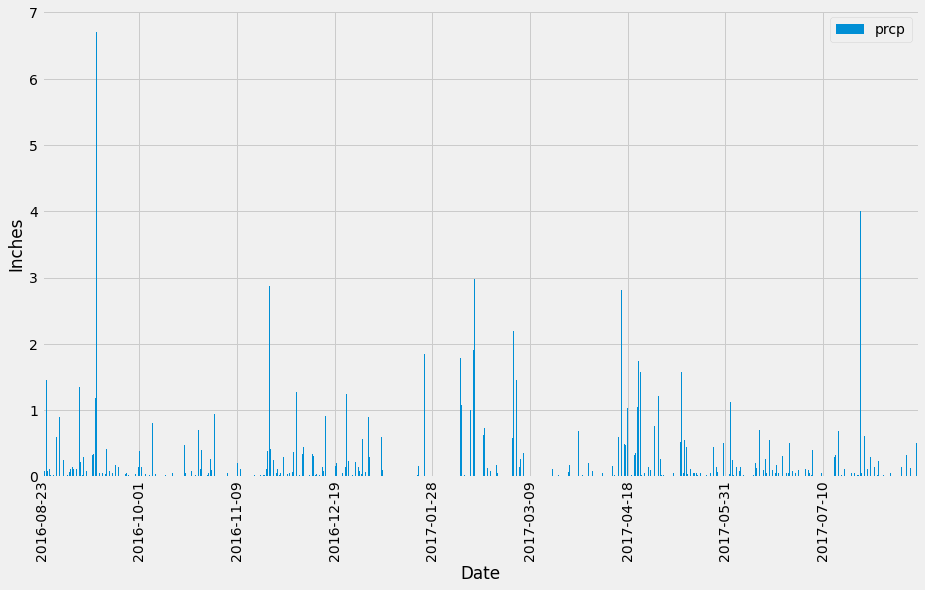

In [26]:
# Plot the results using the DataFrame plot method.
dates_count = len(dataprcp_year_ago_df.index)

dataprcp_year_ago_df.plot(kind = 'bar',y = 'prcp')

tick_locations = [value for value in np.arange(0, dates_count, 225)]
labels = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18',\
          '2017-05-31','2017-07-10']
plt.xticks(tick_locations, labels, rotation = 90)
#plt.legend('precipitation', loc = 'center')
plt.ylabel('Inches')
plt.xlabel('Date')
#plt.tight_layout()
plt.show();

## Station Analysis

In [27]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"There are {station_count} stations.")

There are 9 stations.


In [28]:
# Names of stations.
stat_name_stmt = session.query(Station.name).order_by(Station.name).statement
stat_name_df = orm_query_to_dataframe(stat_name_stmt)
stat_name_df

,name
0,"HONOLULU OBSERVATORY 702.2, HI US"
1,"KANEOHE 838.1, HI US"
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,"MANOA LYON ARBO 785.2, HI US"
4,"PEARL CITY, HI US"
5,"UPPER WAHIAWA 874.3, HI US"
6,"WAIHEE 837.5, HI US"
7,"WAIKIKI 717.2, HI US"
8,"WAIMANALO EXPERIMENTAL FARM, HI US"


In [29]:
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [30]:
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = session.query(func.count(Measurement.station).label('station_count'), Station.name)
query = query.join(Station, Measurement.station == Station.station).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc())

for row in query:
    print(f"{row.name}:    {row.station_count}")

print("")
print(f"The most active station is {query[0].name}, with a count of {query[0].station_count}.")

WAIHEE 837.5, HI US:    2772
WAIKIKI 717.2, HI US:    2724
KANEOHE 838.1, HI US:    2709
WAIMANALO EXPERIMENTAL FARM, HI US:    2669
MANOA LYON ARBO 785.2, HI US:    2612
KUALOA RANCH HEADQUARTERS 886.9, HI US:    2202
HONOLULU OBSERVATORY 702.2, HI US:    1979
PEARL CITY, HI US:    1372
UPPER WAHIAWA 874.3, HI US:    511

The most active station is WAIHEE 837.5, HI US, with a count of 2772.


In [32]:
# Station count DataFrame.
query1 = session.query(func.count(Measurement.station).label('station_count'), Station.name, Measurement.station)
query1_stmt = query1.join(Station, Measurement.station == Station.station).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).statement
stat_count_df = orm_query_to_dataframe(query1_stmt)
stat_count_df

,station_count,name,station
0,2772,"WAIHEE 837.5, HI US",USC00519281
1,2724,"WAIKIKI 717.2, HI US",USC00519397
2,2709,"KANEOHE 838.1, HI US",USC00513117
3,2669,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523
4,2612,"MANOA LYON ARBO 785.2, HI US",USC00516128
5,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830
6,1979,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918
7,1372,"PEARL CITY, HI US",USC00517948
8,511,"UPPER WAHIAWA 874.3, HI US",USC00518838


## # The most active station: WAIHEE 837.5, HI US     station id: USC00519281

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

query2 = session.query(Measurement.station, Station.name, func.min(Measurement.tobs).label('min_temp'),\
                       func.max(Measurement.tobs).label('max_temp'), func.avg(Measurement.tobs).label('avg_temp'))
query2_stmt = query2.join(Station, Measurement.station == Station.station).group_by(Measurement.station).\
              having(Measurement.station =='USC00519281').statement
most_active_df = orm_query_to_dataframe(query2_stmt)
most_active_df

,station,name,min_temp,max_temp,avg_temp
0,USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781


In [34]:
# Choose the station with the highest number of temperature observations.
# Station count DataFrame.
query3 = session.query(func.count(Measurement.tobs).label('temp_count'), Station.name, Measurement.station)
query3_stmt = query3.join(Station, Measurement.station == Station.station).group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).statement
station_temp_count_df = orm_query_to_dataframe(query3_stmt)

print("")
print(f"The station with highest number of observations is {station_temp_count_df.loc[0, 'name']}, \
with a count of {station_temp_count_df.loc[0, 'temp_count']}.")

station_temp_count_df


The station with highest number of observations is WAIHEE 837.5, HI US, with a count of 2772.


,temp_count,name,station
0,2772,"WAIHEE 837.5, HI US",USC00519281
1,2724,"WAIKIKI 717.2, HI US",USC00519397
2,2709,"KANEOHE 838.1, HI US",USC00513117
3,2669,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523
4,2612,"MANOA LYON ARBO 785.2, HI US",USC00516128
5,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830
6,1979,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918
7,1372,"PEARL CITY, HI US",USC00517948
8,511,"UPPER WAHIAWA 874.3, HI US",USC00518838


## Station with higest number of temperature observations:
    * Station: WAIHEE 837.5, HI US
    * Station id: USC00519281

In [35]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
waihee_df = measurement_df[measurement_df['station'] == 'USC00519281'].sort_values(by = 'date').reset_index()
waihee_df

,index,id,station,date,prcp,tobs
0,12187,12188,USC00519281,2010-01-01,0.15,70.0
1,12188,12189,USC00519281,2010-01-02,0.00,62.0
2,12189,12190,USC00519281,2010-01-03,0.00,74.0
3,12190,12191,USC00519281,2010-01-04,0.00,75.0
4,12191,12192,USC00519281,2010-01-05,0.00,74.0
...,...,...,...,...,...,...
2767,14954,14955,USC00519281,2017-08-14,0.00,77.0
2768,14955,14956,USC00519281,2017-08-15,0.32,77.0
2769,14956,14957,USC00519281,2017-08-16,0.12,76.0
2770,14957,14958,USC00519281,2017-08-17,0.01,76.0


In [36]:
# The last 12 months of temperature observations for WAIHEE 837.5, HI US.
temp_last_date = dt.date(2017, 8 ,18)
temp_query_date = temp_last_date - dt.timedelta(days=365)
print("Query Date: ", temp_query_date)
print(type(temp_query_date))

Query Date:  2016-08-18
<class 'datetime.date'>


In [37]:
# Perform query for date >= 2016-08-23 on the measurements table and filter by Measurement.station == 'USC00519281'.
temp_stmt = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= temp_query_date).\
            filter(Measurement.station == 'USC00519281').order_by(Measurement.date).statement
temp_year_ago_df = orm_query_to_dataframe(temp_stmt)
temp_year_ago_df.set_index('date', inplace=True)
temp_year_ago_df.head()    #info()  

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


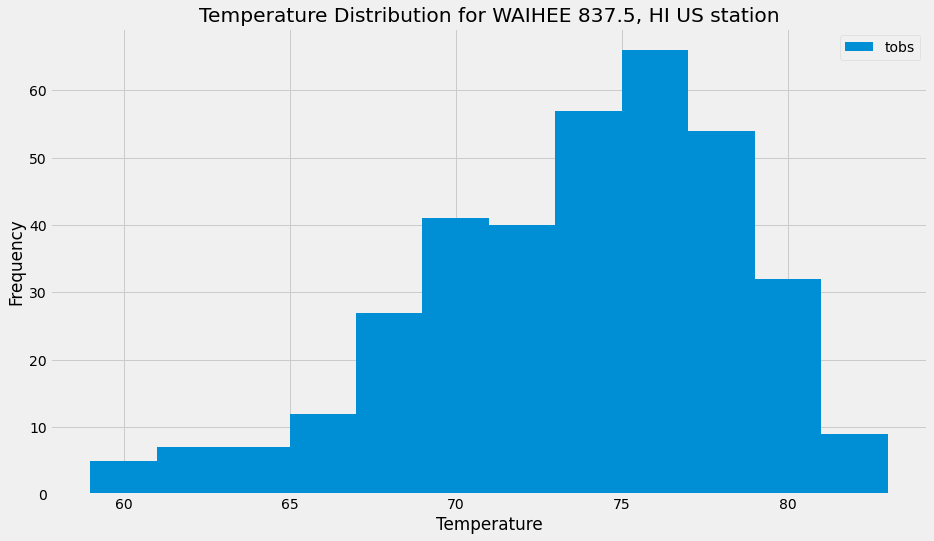

In [38]:
# Plot the results as a histogram with bins=12.
temp_year_ago_df['tobs'].plot(kind = 'hist', bins = 12, legend = True,\
                              title= 'Temperature Distribution for WAIHEE 837.5, HI US station')
plt.xlabel('Temperature');

# Bonus Challenge Assignment

## Temperature Analysis I
    * Identify the average temperature in June and December at all stations across all available years in the dataset.
    * Use the t-test to determine whether the difference in the means is statistically significant. 
    * Will you use a paired t-test, or an unpaired t-test? Why?
This is a paired sample t-test situation. We have the average temperature for each station in June and the corresponding   average temperature in December. Each data pair refers to the same station.

In [39]:
# Find the average temperature in JUNE for ALL stations.

jun_query = session.query(Measurement.station, Station.name, func.avg(Measurement.tobs).label('Jun_avg_temp'))
jun_query_stmt = jun_query.join(Station, Measurement.station == Station.station).filter(func.strftime("%m", Measurement.date) == "06").\
                  group_by(Measurement.station).order_by(Measurement.station).statement
jun_query_df = orm_query_to_dataframe(jun_query_stmt)
jun_query_df

,station,name,Jun_avg_temp
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",74.139394
1,USC00513117,"KANEOHE 838.1, HI US",74.050847
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",76.005376
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",71.937220
4,USC00517948,"PEARL CITY, HI US",76.655405
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",73.394737
6,USC00519281,"WAIHEE 837.5, HI US",73.271186
7,USC00519397,"WAIKIKI 717.2, HI US",77.559322
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",76.668103


In [40]:
# Find the average temperature in DECEMBER for ALL stations.
dec_query = session.query(Measurement.station, Station.name, func.avg(Measurement.tobs).label('Dec_avg_temp'))
dec_query_stmt = dec_query.join(Station, Measurement.station == Station.station).filter(func.strftime("%m", Measurement.date) == "12").\
                  group_by(Measurement.station).order_by(Measurement.station).statement
dec_query_df = orm_query_to_dataframe(dec_query_stmt)
dec_query_df

,station,name,Dec_avg_temp
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",69.684211
1,USC00513117,"KANEOHE 838.1, HI US",71.069444
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",73.224719
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",69.291262
4,USC00517948,"PEARL CITY, HI US",71.834862
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",72.421053
6,USC00519281,"WAIHEE 837.5, HI US",69.903226
7,USC00519397,"WAIKIKI 717.2, HI US",71.109524
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",72.433333


In [41]:
# Merge the two data sets along station
complete_df = pd.merge(jun_query_df, dec_query_df, how="left", on=["station", "station"], suffixes=('_j', '_d'))
complete_df

,station,name_j,Jun_avg_temp,name_d,Dec_avg_temp
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",74.139394,"HONOLULU OBSERVATORY 702.2, HI US",69.684211
1,USC00513117,"KANEOHE 838.1, HI US",74.050847,"KANEOHE 838.1, HI US",71.069444
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",76.005376,"KUALOA RANCH HEADQUARTERS 886.9, HI US",73.224719
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",71.937220,"MANOA LYON ARBO 785.2, HI US",69.291262
4,USC00517948,"PEARL CITY, HI US",76.655405,"PEARL CITY, HI US",71.834862
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",73.394737,"UPPER WAHIAWA 874.3, HI US",72.421053
6,USC00519281,"WAIHEE 837.5, HI US",73.271186,"WAIHEE 837.5, HI US",69.903226
7,USC00519397,"WAIKIKI 717.2, HI US",77.559322,"WAIKIKI 717.2, HI US",71.109524
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",76.668103,"WAIMANALO EXPERIMENTAL FARM, HI US",72.433333


In [42]:
jun_dec_df = complete_df.filter(['name_j', 'Jun_avg_temp', 'Dec_avg_temp'])
jun_dec_df.columns = ['station_name', 'Jun_avg_temp', 'Dec_avg_temp']
jun_dec_df

,station_name,Jun_avg_temp,Dec_avg_temp
0,"HONOLULU OBSERVATORY 702.2, HI US",74.139394,69.684211
1,"KANEOHE 838.1, HI US",74.050847,71.069444
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",76.005376,73.224719
3,"MANOA LYON ARBO 785.2, HI US",71.937220,69.291262
4,"PEARL CITY, HI US",76.655405,71.834862
5,"UPPER WAHIAWA 874.3, HI US",73.394737,72.421053
6,"WAIHEE 837.5, HI US",73.271186,69.903226
7,"WAIKIKI 717.2, HI US",77.559322,71.109524
8,"WAIMANALO EXPERIMENTAL FARM, HI US",76.668103,72.433333


In [43]:
# Summary of the paired data.
jun_dec_df[['Jun_avg_temp','Dec_avg_temp']].describe()

,Jun_avg_temp,Dec_avg_temp
count,9.000000,9.000000
mean,74.853510,71.219070
std,1.919588,1.376549
min,71.937220,69.291262
25%,73.394737,69.903226
50%,74.139394,71.109524
75%,76.655405,72.421053
max,77.559322,73.224719


In [44]:
# This is a paired sample t-test situation. We have the average temperature for each station in June 
# and the corresponding average temperature in December. Each data pair refers to the same station.
june = jun_dec_df['Jun_avg_temp']
december = jun_dec_df['Dec_avg_temp']
stats.ttest_rel(june, december)

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

### The test is statistically significant. Reject the null hypothesis in support of the alternative. The average temperature in Hawaii for June was higher (74.85 ± 1.92 degrees) compared to the average temperature in December (71.22 ± 1.38 units). The average difference in the mean temperatures os as much as 3.63 degrees, (t(8)=6.9570, p= 0.0001).

# Temperature Analysis II

### My Trip: Hawaii
### Starting Date: 2017-06-07
### End Date: 2017-07-02
### Query Starts: 2016-06-07
### Query Ends: 2016-07-02


In [45]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    results_statement = session.query(func.min(Measurement.tobs).label('TMIN'), func.max(Measurement.tobs).label('TMAX'), func.avg(Measurement.tobs).label('TAVG')).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).statement
    results_df = pd.read_sql_query(results_statement, session.bind)
    return results_df

# function usage example
example_df = calc_temps('2012-02-28', '2012-03-05')
example_df

,TMIN,TMAX,TAVG
0,62.0,74.0,69.571429


## Vacation Time: 2017-06-07 to 2017-07-02

In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
query_start = '2016-06-07'
query_end = '2016-07-02'
vacation_df = calc_temps(query_start, query_end)
vacation_df

,TMIN,TMAX,TAVG
0,69.0,82.0,76.065476


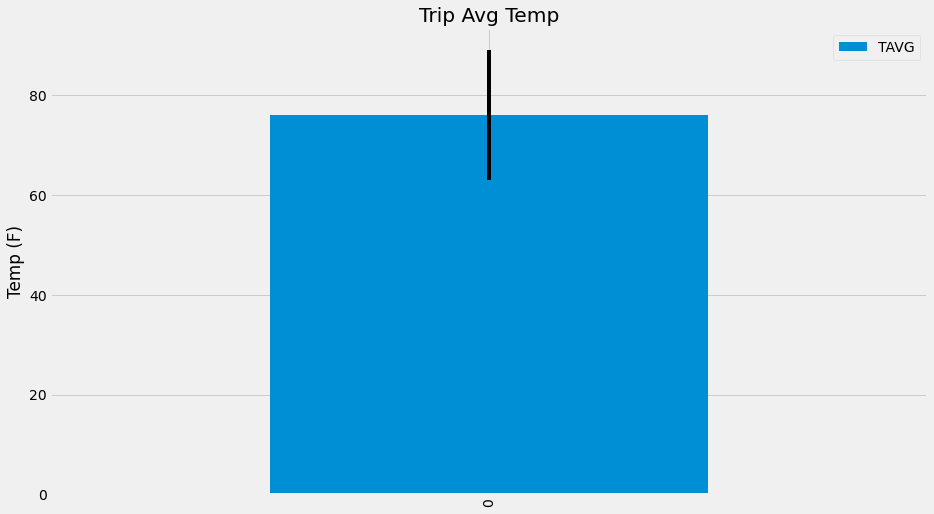

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = vacation_df.loc[0, 'TMAX'] - vacation_df.loc[0, 'TMIN']

vacation_df.plot(kind = 'bar',y = 'TAVG', yerr = error, title = 'Trip Avg Temp')
plt.ylabel('Temp (F)')

#plt.tight_layout()
plt.show();

## Rainfall Analysis

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_query = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp).label('total_rainfall'),\
                               Station.latitude, Station.longitude, Station.elevation)
rainfall_query_stmt = rainfall_query.join(Station, Measurement.station == Station.station).filter(Measurement.date >= query_start).\
filter(Measurement.date <= query_end).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).statement
                                                                            
rainfall_df = orm_query_to_dataframe(rainfall_query_stmt)
rainfall_df

,station,name,total_rainfall,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",14.12,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",5.93,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",3.00,21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2.21,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1.25,21.33556,-157.71139,19.5
5,USC00517948,"PEARL CITY, HI US",0.60,21.39340,-157.97510,11.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.21,21.27160,-157.81680,3.0


## Daily Normals

In [49]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

### Function to calculate daily normals and produce Pandas DataFrame, using start and end dates.

In [54]:
# Create a funtion to calculate daily normals for the duration of the trip.
def daily_normals(start_date, end_date):
    # Develop a list of the dates on the trip using a query.
    trip_dates_query = session.query(Measurement.date.distinct().label('trip_date')).filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).order_by(Measurement.date)
    
    # Create an initial DataFrame for the daily normals, daily_normals_df.
    trip_stmt = trip_dates_query.statement
    daily_normals_df = orm_query_to_dataframe(trip_stmt)
    
    # Iterate over the query results for trip_dates.
    row_index = 0
    for dates in trip_dates_query:
        year_mth_day = dates[0]
        date = year_mth_day[5:]
        
        # Start to calculate the daily normals.
        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
        the_results = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
        
        # The final DataFrameis created with addtion columns: tmin, tavg, tmax
        for tmin, tavg, tmax in the_results:
            daily_normals_df.loc[row_index, 'tmin'] = tmin
            daily_normals_df.loc[row_index, 'tavg'] = round(tavg, 3)
            daily_normals_df.loc[row_index, 'tmax'] = tmax
        
        # Increase the row index.
        row_index += 1

    return daily_normals_df   

In [51]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_daily_normals_df = daily_normals(query_start, query_end)
trip_daily_normals_df

,trip_date,tmin,tavg,tmax
0,2016-06-07,68.0,75.071,81.0
1,2016-06-08,70.0,75.586,81.0
2,2016-06-09,69.0,75.153,81.0
3,2016-06-10,68.0,75.143,81.0
4,2016-06-11,69.0,76.020,84.0
5,2016-06-12,66.0,75.667,83.0
6,2016-06-13,68.0,75.667,81.0
7,2016-06-14,69.0,75.627,81.0
8,2016-06-15,67.0,75.404,81.0
9,2016-06-16,69.0,75.414,81.0


In [52]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
completed_normals_df = trip_daily_normals_df.set_index('trip_date')
completed_normals_df  #head()

,tmin,tavg,tmax
trip_date,,,
2016-06-07,68.0,75.071,81.0
2016-06-08,70.0,75.586,81.0
2016-06-09,69.0,75.153,81.0
2016-06-10,68.0,75.143,81.0
2016-06-11,69.0,76.020,84.0
2016-06-12,66.0,75.667,83.0
2016-06-13,68.0,75.667,81.0
2016-06-14,69.0,75.627,81.0
2016-06-15,67.0,75.404,81.0


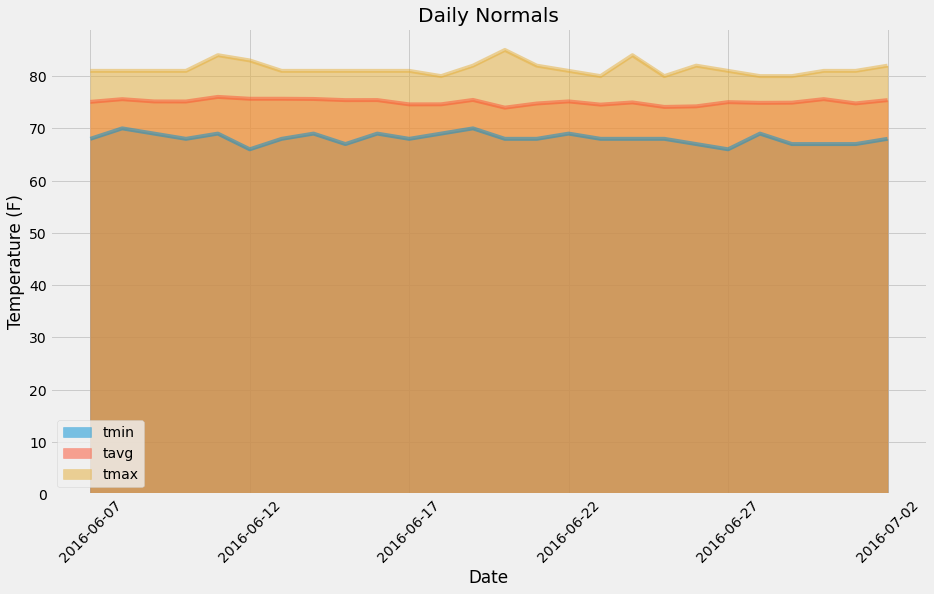

In [53]:
# Plot the daily normals as an area plot with `stacked=False`
completed_normals_df.plot.area(stacked = False)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Temperature (F)')
plt.title('Daily Normals')
plt.show();